# Example Run of Scoring

For demonstration, this file evaluates the model for a sample hyperparameter set:

- Cell size: $\delta_x = \delta_y = 600$ (feet)
- Kernel spatial lengthscale multiplier: $\eta = 1$
- Kernel temporal lengthscale: $l_t = 14$ days
- Cell rotation: $\theta = 0$ radians
- Random Fourier Features: $k = 250$
- Kernel density feature bandwidth: $\lambda = 500$ feet
- Incuded KDE lags: $n = 6$ periods
- KDE window: $w = 3$ days
- Emergency call type: fire emergencies

## LOAD LIBRARIES, PARAMETERS

In [1]:
library(spatstat)
library(splancs)
library(rgeos)
library(data.table)
library(maptools)

#from random.org
set.seed(19775046)


#set of parameters that run quickly for testing
delx=600; dely=600
eta=1; lt=14; theta=0
features=250; kde.bw=500; 
kde.lags=6; kde.win = 3
call.type='fire'

incl_mos = c(10L, 11L, 12L, 1L, 2L, 3L)

aa = delx*dely #forecasted area
lx = eta*250
ly = eta*250

Loading required package: nlme
Loading required package: rpart

spatstat 1.51-0       (nickname: ‘Poetic Licence’) 
For an introduction to spatstat, type ‘beginner’ 

Loading required package: sp

Spatial Point Pattern Analysis Code in S-Plus
 
 Version 2 - Spatial and Space-Time analysis

rgeos version: 0.3-23, (SVN revision 546)
 GEOS runtime version: 3.4.2-CAPI-1.8.2 r3921 
 Linking to sp version: 1.2-4 
 Polygon checking: TRUE 


Attaching package: ‘data.table’

The following object is masked from ‘package:spatstat’:

    shift

Checking rgeos availability: TRUE


## LOAD DATA

- load events points file
- rotate this according to $\theta$ parameter
- load boundary points of city, rotate, and establish origin
- initialize `GridTopology` object

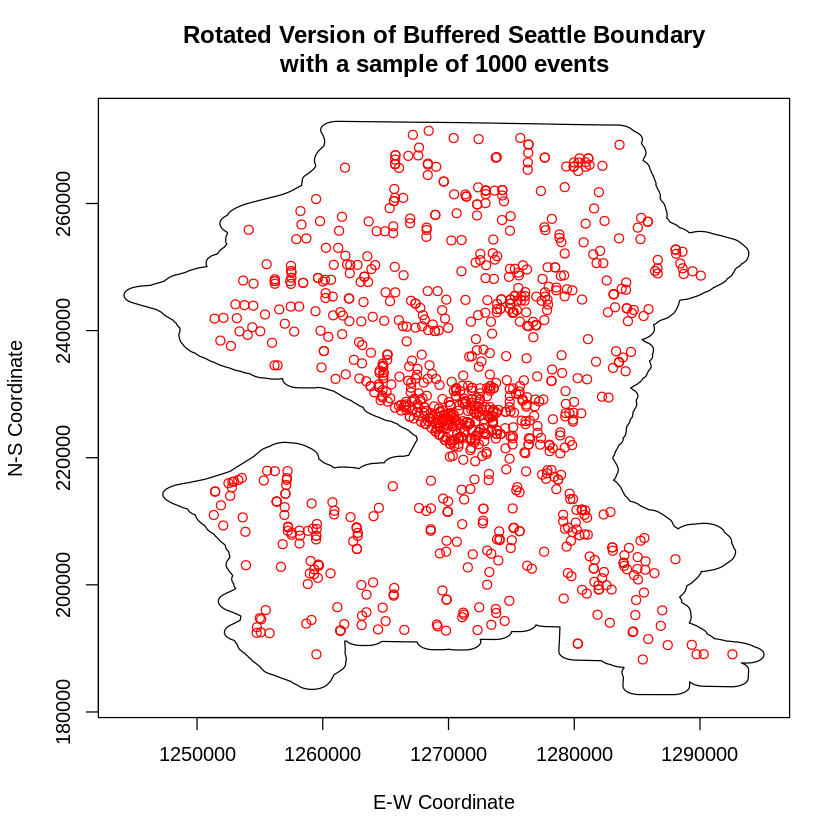

In [2]:
#these files created with get_data notebook
calls = fread(paste0(call.type, '.csv'))
calls[ , date := as.IDate(date)]

# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>=
# ROTATION ----
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>=

#rotation formula, relative to a point (x_0, y_0) that's not origin:
#  [x_0, y_0] + R * [x - x_0, y - y_0]
#  (i.e., rotate the distances from (x_0, y_0) about that point,
#   then offset again by (x_0, y_0))
#  Equivalently (implemented below):
#  (I - R)[x_0, y_0] + R[x, y]
rotate = function(x, y, theta, origin)
  matrix(origin, nrow = length(x), 
         ncol = 2L, byrow = TRUE) %*% (diag(2L) - RT(theta)) + 
  cbind(x, y) %*% RT(theta)
#use the transpose of the rotation matrix to multiply against
#  column vectors of coordinates
RT = function(theta) matrix(c(cos(theta), -sin(theta), 
                              sin(theta), cos(theta)), 
                            nrow = 2L, ncol = 2L)

#use the lower-left corner of data as the origin
#  through which to rotate
#  (side-effect -- the same theta on different
#   call types/horizons will result in different
#   rotated grids, since point0 will likely differ)
point0 = calls[ , c(min(x_lon), min(y_lat))]
calls[ , paste0(c('x', 'y'), '_lat') :=
          as.data.table(rotate(x_lon, y_lat, theta, point0))]

#boundary coordinates of seattle,
#  as a matrix (rotated immediately)
seattle = 
  with(fread('data/seattle_coords.csv'),
       rotate(x, y, theta, point0))

#record range here (after rotation), so that
#  we have the same range 
#  after we subset below
#use full boundary range to be sure
#  we eventually cover the output polygon
xrng = range(seattle[ , 1L])
yrng = range(seattle[ , 2L])
    
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>=
# CREATE GRID ----
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>=

getGTindices <- function(gt) {
  # Obtain indices to rearange data from image (eg. result frim pixellate)
  # so that it conforms with data from GridTopology objects (eg. results
  # from using spkernel2d).
  # Input: gt is a grid topology.
  # Returns an index.
  dimx <- gt@cells.dim[1L]
  dimy <- gt@cells.dim[2L]
  c(matrix(seq_len(dimx*dimy), ncol = dimy, byrow = TRUE)[ , dimy:1L])
}

# from create GridTopology corresponding to pixel image used for crime counts
#   (so that we're sure the output from spatstat & sp overlap properly)
grdtop <- as(as.SpatialGridDataFrame.im(
  pixellate(ppp(xrange=xrng, yrange=yrng), eps=c(delx, dely))), "GridTopology")

# index to rearrange rows in pixellate objects
idx.new <- getGTindices(grdtop)
plot(seattle, main = paste('Rotated Version of Buffered Seattle Boundary',
                           'with a sample of 1000 events', sep = '\n'),
     type = 'l', xlab = 'E-W Coordinate', ylab = 'N-S Coordinate')
invisible(calls[sample(.N, 1000), points(x_lon, y_lat, col = 'red')])

## CREATE PRIMARY DATA

- primary data consists of grid centroid/time pairs & counts of events over each

In [3]:
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>=
# CREATE DATA TABLE OF CALLS ----
# 1) aggregate at lag.window level for included periods
# 2) aggregate at forecasting horizon level for included periods
# 3) merge previous results
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>=

#Before subsetting, get indices of ever-crime cells
## Per here, these are always sorted by x,y:
##   https://github.com/spatstat/spatstat/issues/37
## NB: this must be done within-loop
##   since it depends on delx & dely
incl_ids = 
  with(calls, as.data.table(pixellate(ppp(
    #pixellate counts dots over each cell,
    #  and appears to do so pretty quickly
    x = x_lon, y = y_lat,
    #ppp complains when given crimes with 
    #  identical coordinates (which is fine
    #  for our purposes), so set check = F
    xrange = xrng, yrange = yrng, check = FALSE),
    #idx.new here converts from spatstat
    #  indexing to GridTopology index order
    #  of the grid cells
    eps = c(delx, dely)))[idx.new]
    #find cells that ever have a crime (value > 0)
  )[value > 0, which = TRUE]

## Associating each event with an interval
##   of width equal to `horizon`, 
##   cascading backwards from the 
##   competition forecasting horizon

# how long is one period for this horizon?
#   NB: these are not great approximations
#       of the horizon lengths, but what is
#       crucial is to line up with the
#       ultimate forecasting horizons,
#       e.g. 1m is March 1 - 31
pd_length = 7L
# how many periods are there in one year for this horizon?
one_year = 52L
# *** TO DO ***
# how many total periods are there in the data?
#   2013/14/15/16/(17), though 17 not used here
n_pds = 5L*one_year

#actually easier/quicker to deal with
#  integer representation of the dates
calls[ , date_int := unclass(date)]
#all dates on which an event occurred
unq_crimes = calls[ , unique(date_int)]

march117 = unclass(as.IDate('2017-03-01'))
#all possible period start dates
start = march117 - (seq_len(n_pds) - 1L) * pd_length
#eliminate irrelevant (summer) data
#  and non-testable data after testing dates in 2016
start = start[month(as.IDate(start, origin = '1970-01-01')) %in% incl_mos & 
                start <= march117 - one_year*pd_length]
#all period end dates (nonoverlapping with starts)
end = start + pd_length - 1L
#for feeding to foverlaps
windows = data.table(start, end, key = 'start,end')

call_start_map = data.table(date_int = unq_crimes)
call_start_map[ , start_date := 
                   foverlaps(data.table(start = date_int, 
                                        end = date_int),
                             windows)$start]

#finally, add the interval start date associated with
#  each date of occurrence
calls[call_start_map, start_date := i.start_date, on = 'date_int']

#Create the LHS variable -- counts of crimes
#  in each cell, in each interval (indexed by start_date)
X = calls[!is.na(start_date), as.data.table(pixellate(ppp(
  x = x_lon, y = y_lat, xrange = xrng, yrange = yrng, check = FALSE),
  #reorder using GridTopology - im mapping
  eps = c(x = delx, dely)))[idx.new],
  #subset to eliminate never-crime cells
  keyby = start_date][ , I := rowid(start_date)][I %in% incl_ids]

## *** TO DO ***
#Use four holdout periods -- one for each possible
#  year -- to stabilize jumpy prediction validity
for (ii in 1:4) {
  test_start = march117 - ii * one_year*pd_length
  X[start_date <= test_start, 
    paste0('train_', 17 - ii) := start_date < test_start]
}

## ADD FEATURES
- KDE lags
- Random Fourier Features

In [4]:
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>=
# Add lagged KDE covariates
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>=

# create sp object of crimes
to.spdf = function(dt) {
  SpatialPointsDataFrame(
    coords = dt[ , cbind(x_lon, y_lat)],
    data = dt[ , -c('x_lon', 'y_lat')],
    proj4string = CRS("+init=epsg:4326"))
}
calls.sp = to.spdf(calls)
#convert to DT to speed up repeated
#  subsetting by sorting the data
#  to leverage good DT internals
calls.sp@data = setDT(calls.sp@data)
setkey(calls.sp@data, date_int)

#Given a SpatialPointsDF, a start_date,
#  and a lag number, calculate the
#  KDE corresponding to the kde.win
#  days spanning that horizon
compute.kde <- function(pts, start, lag.no) {
  #subset using data.table for speed;
  #  first get the indices via [.data.table
  #  of which crimes are included in that lag number
  idx = pts@data[date_int %between% 
                   #between start - kde.win*lag.no
                   #  and start - (lag.no - 1)*kde.win - 1
                   (start - kde.win*lag.no + c(0, kde.win - 1L)), 
                 which = TRUE]
  #if no events found, just return 0
  #  (spkernel2d handles this with varying degrees of success)
  if (!length(idx)) return(rep(0, length(incl_ids)))
  kde = spkernel2d(pts = pts[idx, ],
                   #immediately exclude never-crime cells
                   poly = seattle, h0 = kde.bw, grd = grdtop)[incl_ids]
}

#start_lag facilitates using within-group lapply
#  in the next command, see below
start_lag = CJ(start = start, lag = seq_len(kde.lags))

#for up through kde.lags total lags to include,
#  compute the associated KDE and add it as a
#  column associated with the grid cell;
#  do this by start_date to complete
#  the lagged-KDE specification on the RHS of the model
cat('Adding KDEs')
RHS = start_lag[ , 
    c(I = list(incl_ids),
      lapply(setNames(lag, paste0('lag', lag)), compute.kde,
             pts = calls.sp, start = .BY$start)), by = start]
cat('\nDone KDEs')
    
#join to our main data.table
X = X[RHS, on = c(start_date = 'start', 'I')]

# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
# Add Random Fourier Features ----
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

#project -- these are the omega * xs
proj = X[ , cbind(x, y, start_date)] %*% 
  (matrix(rt(3L*features, df = 2.5), nrow = 3L)/c(lx, ly, lt))

#now convert to data.table to use fwrite,
#  also moving into VW-parseable format
incl.kde = grep("^lag", setNames(nm = names(X)), value = TRUE)

# check for NAs in the features -- still happens
#   for long, thin cell sizes since we didn't buffer
#   the boundary coordinates enough, and these examples
#   end up returning some NA KDE values because of
#   how spkernel2d decides which cells are within/not
#   the designated boundary coordinates
stopifnot(all(!is.na(X$start_date)))

phi.dt =
  X[ , {
    #some nonsense about how get works in j --
    #  if we define coln_to_vw in global environment,
    #  lapply(incl.kde, coln_to_vw) fails because
    #  get doesn't find the variables.
    #  Probably some workaround, but w/e
    coln_to_vw = function(vn) { 
      V = get(vn)
      #scale up to minimize wasted 0s
      #  (eschewing z-scores somewhat arbitrarily)
      val = V * 10^(abs(round(mean(log10(V[V>0])))))
      #another check on whether we created any
      #  missing KDE values -- you might notice
      #  this happened a lot, much to our chagrin
      if (any(is.nan(val)))
        stop('NaNs detected! Current parameters:',
             paste(args, collapse = '/'))
      sprintf("%s:%.5f", vn, val)
    }
    c(list(v = value, 
           #|kdes and |rff define namespaces,
           #  which we didn't ultimately use
           #  (though could have -- more of
           #   a time constraint than anything)
           l = paste0(I, "_", start_date, "|kdes")), 
      lapply(incl.kde, coln_to_vw),
      list(rff_namespace = '|rff'))
  }]

#about to assign a lot of columns using set --
#  will fail if we don't warn data.table that
#  phi.dt is going to grow substantially
if (features > 500L) invisible(alloc.col(phi.dt, 3L*features))
#create the features
#  previously explored alternative:
#  assign cos/sin projection as matrix:
#  phi = cbind(cos(proj), sin(proj))/sqrt(features)
#  then assign to phi.dt column-wise,
#  but this _appears_ to be slower than implicitly
#  creating this as below by taking sin/cos 
#  simultaneously with assigning to phi.dt.
cat('\nStarting Feature Addition')
fkt = 1/sqrt(features)
for (jj in 1L:features) {
  if (jj %% 50 == 0) cat('\nAdded', jj, 'features')
  pj = proj[ , jj]
  set(phi.dt, j = paste0(c("cos", "sin"), jj), 
      #these are the paired random fourier features;
      #  truncating at 5 digits to rein in file size
      value = list(sprintf("cos%i:%.5f", jj, fkt*cos(pj)),
                   sprintf("sin%i:%.5f", jj, fkt*sin(pj))))
}
rm(proj)

Adding KDEs
Done KDEs
Starting Feature Addition
Added 50 features
Added 100 features
Added 150 features
Added 200 features
Added 250 features

## TRAIN POISSON REGRESSION WITH VOWPAL WABBIT

In [ ]:
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
# WRITE VW FILES ----
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
tdir = "tmpf"

#run over these values of alpha (very fast to do within-loop)
alpha_variations = seq(0, 1, length.out = 20)

#these are all the indicators for training holdouts
train_variations = grep('^train', names(X), value = TRUE)

#also relatively fast to recycle through VW
#  runs once we have a data set, so
#  leverage the fixed cost of data
#  creation to do so
l1s = l2s = c(0, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3)
vw_variations = CJ(l1 = l1s, l2 = l2s)

#when we're at the minimum forecast area, we must round up
#  to be sure we don't undershoot; when at the max,
#  we must round down; otherwise, just round
which.round = function(x)
  if (x > 0) {if (x < 1) round else floor} else ceiling

#for storing the output, taking care to
#  store things in the correct order
#  relative to our work flow
scores =
  CJ(train_set = train_variations,
     delx = delx, dely = dely,
     alpha = alpha_variations,
     eta = eta, lt = lt, theta = theta,
     k = features, l1 = l1s, l2 = l2s,
     kde.bw = kde.bw, kde.lags = kde.lags,
     kde.win = kde.win, pei = 0, pai = 0)

#for easy/clean updating syntax
setkey(scores, train_set, alpha, l1, l2)

#loop over using each year's holdout test set to calculate PEI/PAI
for (train in train_variations) {
  #these are the test data
  test_idx = !X[[train]]
  
  #temporary files -- include lots of
  #  potential debugging info in the file name
  filename = paste('arws', train, call.type, delx,
                   dely, eta, lt, theta, features, kde.bw,
                   kde.lags, kde.win, sep = '_')
  #write the training data to:
  train.vw = paste0(tdir, '/train_', filename)
  #write the test data to:
  test.vw = paste0(tdir,'/test_', filename)
  #simply append .cache suffix to make it easier
  #  to track association when debugging
  cache = paste0(train.vw, '.cache')
  #write the predictions to:
  pred.vw = paste0(tdir, '/pred_', filename)
  
  fwrite(phi.dt[!test_idx], train.vw,
         sep = " ", quote = FALSE, col.names = FALSE)
  cat('\nWrote training data for', train)
  fwrite(phi.dt[test_idx], test.vw,
         sep = " ", quote = FALSE, col.names = FALSE)
  cat('\nWrote test data for', train)
  
  # used to delete phi.dt & subset X here to cut down on
  #   RAM hit. optionally, could split this into two
  #   for loops -- one to write out the files (could then
  #   delete phi.dt) and then another to run VW

  #Calculate PAI denominator here since it is the
  #  same for all variations of tuning parameters,
  #  given the input parameters (delx, etc.)
  NN = X[test_idx, sum(value)]
  
  # looping over calls to VW
  for (ii in seq_len(nrow(vw_variations))) {
    # print(ii)
    L1 = vw_variations[ii, l1]
    L2 = vw_variations[ii, l2]
    #need a new model file for each run
    model = tempfile(tmpdir = tdir, pattern = "model")
    #train with VW
    call.vw = paste('vw --loss_function poisson --l1', L1, 
                    '--l2', L2, train.vw, '--cache_file', cache, 
                    '--passes 200 -f', model)
    #ingore.stderr since this is where system outputs,
    #  and having all of the VW output (save for debugging)
    #  was just cluttering up the output files
    system(call.vw, ignore.stderr = TRUE)
    cat('\nVW training complete')
    #training data now stored in cache format,
    #  so can delete original (don't need to, but this is a useful
    #  check to force an error if s.t. wrong with cache)
    if (file.exists(train.vw)) invisible(file.remove(train.vw))
    #test with VW
    system(paste('vw -t -i', model, '-p', pred.vw,
                 test.vw, '--loss_function poisson'),
           ignore.stderr = TRUE)
    cat('\nVW testing complete')
    invisible(file.remove(model))
    
    preds =
      fread(pred.vw, sep = " ", header = FALSE, col.names = c("pred", "I_start"))
    invisible(file.remove(pred.vw))
    #wrote 2-variable label with _ to fit VW guidelines;
    #  now split back to constituents so we can join
    preds[ , c("I", "start_date", "I_start") :=
             c(lapply(tstrsplit(I_start, split = "_"), as.integer),
               list(NULL))]
    
    #VW predictions are in logs for poisson regression,
    #  so exponentiate to get counts
    X[preds, pred.count := exp(i.pred), on = c("I", "start_date")]
    rm(preds)
    
    #Calculate all cell rankings, then
    #  loop through alpha to include different numbers of them
    
    #Here are the rankings of the cells according to our predictions
    X[X[test_idx, .(tot.pred = sum(pred.count)), by = I
        ][order(-tot.pred), .(I, rank = .I)],
      rank := i.rank, on = 'I']
    
    #Here are the TRUE rankings of the cells
    X[X[test_idx, .(tot.crimes = sum(value)), by = I
        ][order(-tot.crimes), .(I, true_rank = .I)],
      true_rank := i.true_rank, on = 'I']
    
    # loop over alpha values
    ##this loop can probably be vectorized better...
    for (AA in alpha_variations) {
      #6969600 ft^2 = .25 mi^2 (minimum forecast area);
      #triple this is maximum forecast area
      n.cells = as.integer(which.round(AA)(6969600*(1+2*AA)/aa))
      #n.cells = as.integer(ceiling(6969600/aa))

      #how well did we do? lower-case n in the PEI/PAI calculation
      nn = X[rank <= n.cells & test_idx, sum(value)]
      #PEI denominator -- total crimes in the TRUE top n.cells
      N_star = X[true_rank <= n.cells & test_idx, sum(value)]
      
      scores[.(train, AA, L1, L2),
             c('pei', 'pai') :=
               #pre-calculated the total area of portland (in ft^2)
               .(nn/N_star, pai = (nn/NN)/(aa*n.cells/4117777129))]
    }
    #reset ranking for next run
    X[ , rank := NULL]
  }
  invisible(file.remove(cache, test.vw))
}

## PRINT OUTPUT OF RUN

In [ ]:
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
# PRINT SCORES TO STDOUT  ====
# used when capturing score with Spearmint
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

best.pai = scores[ , max(pai), by = train_set][ , mean(V1)]
best.pei = scores[ , max(pei), by = train_set][ , mean(V1)]
best_scores = paste(best.pai,best.pei, sep = '/')
best_scores = paste0('[[[', best_scores,']]]')
print(best_scores)

# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
# WRITE RESULTS FILE 
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

ff = paste0("scores/", 'ar_ws_my_',call.type, "_", job_id, ".csv")
fwrite(scores, ff, append = file.exists(ff))